In [1]:
#pip install statsmodels

In [2]:
#pip install pmdarima


In [3]:
import pandas as pd
pd.options.mode.chained_assignment = None #remove warning masseges from panda
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationary test
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA #this package doesn't work anymore and was switched to the one underneth
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima

In [4]:
POS = pd.read_csv('/Users/nawaf/Desktop/graduation project/POS_monthly_2023.csv',index_col='Date', parse_dates=True)

In [5]:
POS = pd.DataFrame(POS)

<h4> Exploring and cleaning Data

In [6]:
POS.head(5)

,Total
Date,
Jan-15,32156481.0
Feb-15,29603197.0
Mar-15,32793427.0
Apr-15,30356911.0
May-15,33099974.0


In [7]:
POS.describe()

,Total
count,9.700000e+01
mean,2.088249e+08
std,2.062546e+08
min,2.960320e+07
25%,5.215320e+07
50%,1.063572e+08
75%,3.465955e+08
max,6.919239e+08


In [8]:
#checking for Nan values
POS.isna().values.any()

True

In [9]:
POS[POS.index.isna()]

,Total
Date,


seeing the NaN rows we can conclude that they are a mistake, so we can remove them

In [10]:
clean_POS = POS.dropna()

In [11]:
#checking for duplicated in date column.
clean_POS.index.duplicated().any()

False

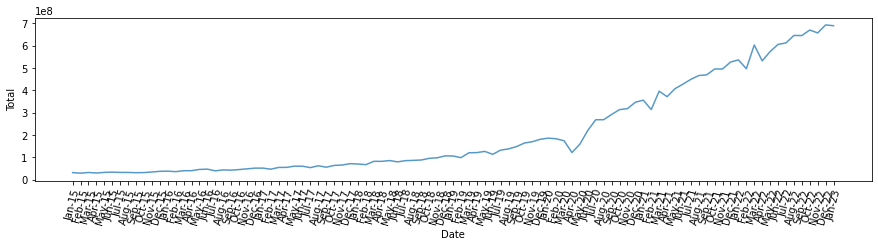

In [12]:
#making line plot 
plt.xticks(rotation=75)
fig = plt.gcf()
fig.set_size_inches(15, 3)
scatter = sns.lineplot(x="Date", y="Total", 
                          sizes=(40, 800), alpha=0.75, palette="BrBG", legend=False,
                          data=clean_POS)
plt.show()

<h3> Testing stationary

In [13]:
#function to test statonarity using Dickey-fuller test and ploting it 
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
  
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    #Plot rolling statistics
    fig = plt.gcf()
    fig.set_size_inches(15, 3)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.xticks(rotation=75)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Results of Dickey Fuller Test:
Test Statistic                 -0.420112
p-value                         0.906686
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


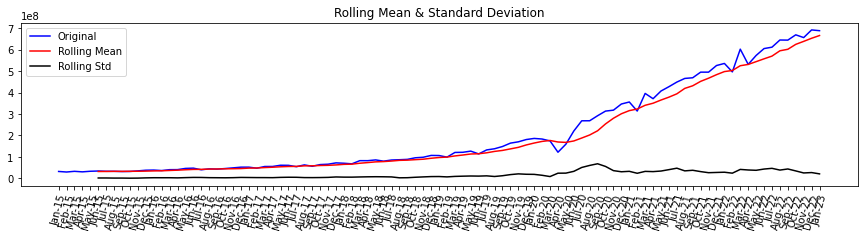

In [83]:
test_stationarity(clean_POS)

<h4> since p-value > 0.05 it's not stationary
so we will try transforming it with taking the first difference

Results of Dickey Fuller Test:
Test Statistic                 -1.188642
p-value                         0.678463
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


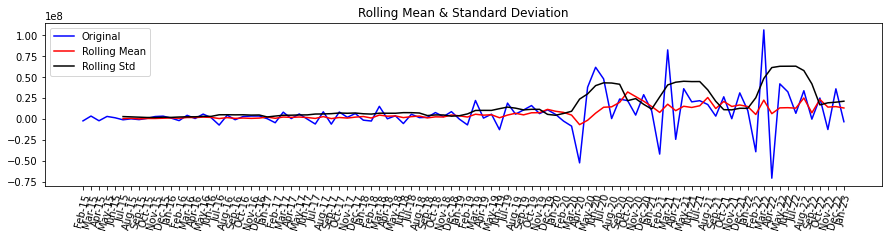

In [15]:
test_stationarity(clean_POS.diff().dropna())

<h5> p-value still high, so we will transform the data again by taking the log <h5>

Results of Dickey Fuller Test:
Test Statistic                 -5.104558
p-value                         0.000014
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


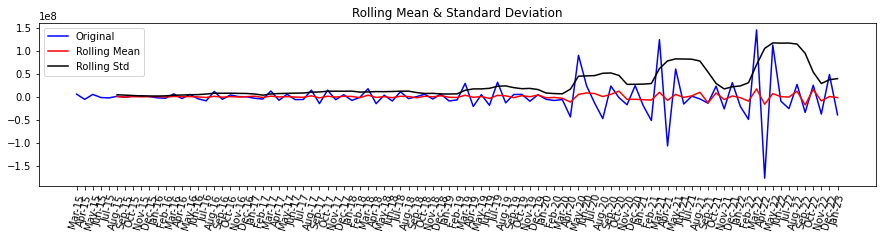

In [16]:
test_stationarity(clean_POS.diff().diff().dropna())

<h4> since the data got stationary after the seconed diffrence, then the d in ARIMA(p,d,q) is equal to 2

/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


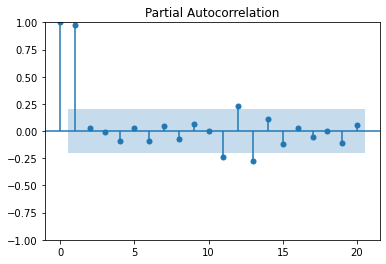

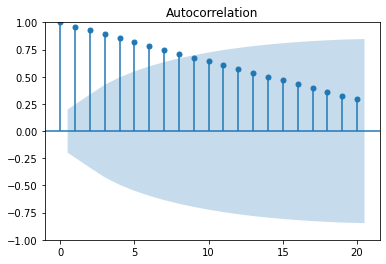

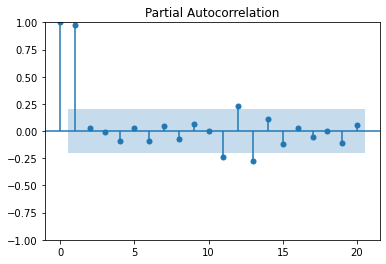

In [62]:
plot_acf(clean_POS)
plot_pacf(clean_POS)

In [61]:
#function to compare models using AIC and BIC scores
def assess_arima(model):
    AIC = model.aic
    BIC = model.bic
    KPI = {
        'AIC':AIC,
        'BIC':BIC,
        }   
    for key in KPI:
        print(key, '=', KPI[key])

<h3> since autocorrelation decay to zero, and partial autocorrelation cuts off after the 2nd itme lag, the model is ARIMA(0,2,2)

In [69]:
print(ARIMA(clean_POS, order=(0,2,2)).fit().summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1735.947
Date:                Mon, 20 Mar 2023   AIC                           3477.893
Time:                        23:11:39   BIC                           3485.555
Sample:                             0   HQIC                          3480.989
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4228      0.087    -16.387      0.000      -1.593      -1.253
ma.L2          0.4819      0.077      6.288      0.000       0.332       0.632
sigma2      6.206e+14        nan        nan        n

/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
#print(ARIMA(clean_POS, order=(1,2,1)).fit().summary())

<h5> from the result we find that ARIMA(0,2,2) has lowest AIC and BIC, now I'll split the data into train/test

In [19]:
#function that shows mae, mape, mse and rmse between test data and predicted data
def KPI(test_data,y_pred):
    mae = mean_absolute_error(y_true=test_data, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=test_data, y_pred=y_pred)
    mse = mean_squared_error(y_true=test_data, y_pred=y_pred)
    rmse = np.sqrt(mse)
    #corr = np.corrcoef(y_pred.Total, test_data.Total)
    KPI = {
        'mape':mape,
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        #'corr':corr
    }   
    for key in KPI:
        print(key, '=', KPI[key])

In [20]:
split_index = int(0.80 * len(clean_POS))
train_data = clean_POS.iloc[:split_index, :]
test_data = clean_POS.iloc[split_index:, :]


In [70]:
model = ARIMA(train_data, order=(0,2,2)).fit()
y_pred = pd.DataFrame(index= test_data.index)
y_pred['Total'] = model.forecast(len(test_data)).values

/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


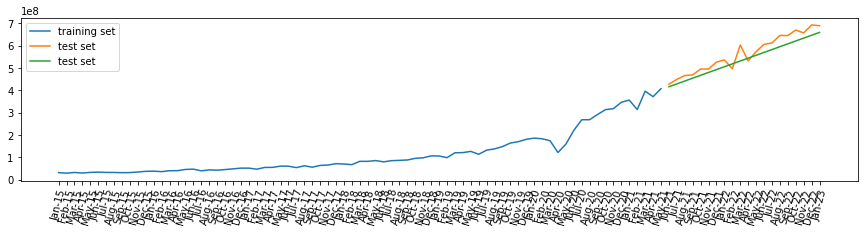

In [71]:
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.plot(train_data.dropna(), label = 'training set')
plt.plot(test_data.dropna(), label='test set')
plt.plot(y_pred, label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 

In [72]:
KPI(test_data=test_data,y_pred=y_pred)

mape = 0.052065296663275175
mae = 30086576.721661
mse = 1123490946032468.2
rmse = 33518516.465268392


<h4> from the result of mse,mape,mae and rmse, we conclude that our origingl model ARIMA(1,2,1) is better

In [24]:
date_index = pd.date_range(start='2023-02',end= '2025-02', freq='M')

In [73]:
model = ARIMA(clean_POS, order=(0,2,2)).fit()
forecast = model.forecast(len(date_index), alpha=0.05)

/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [74]:
get_forecast = model.get_forecast(steps=len(date_index),dynamic=True)
confidence_intervals = get_forecast.conf_int()

/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [75]:
forecast = pd.DataFrame(forecast.values, index=date_index, columns=['Values'])

In [28]:
CI = pd.DataFrame(confidence_intervals.values, index=date_index,columns=['lower_CI', 'Upper_CI'])

In [76]:
forecast.index = forecast.index.strftime("%b-%y")

In [77]:
CI.index = CI.index.strftime("%b-%y")

AttributeError: 'Index' object has no attribute 'strftime'

Plot diagnostics
It is important to know when we need to go back to the drawing board in model design. In this exercise we will use 4 common plots to decide whether a model is a good fit to some data.


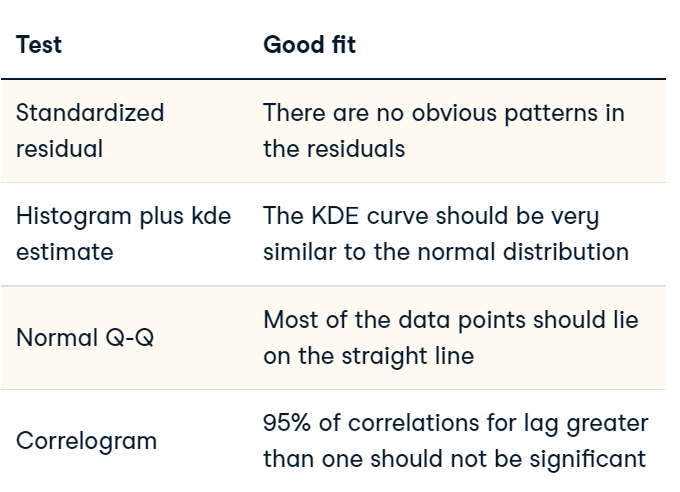

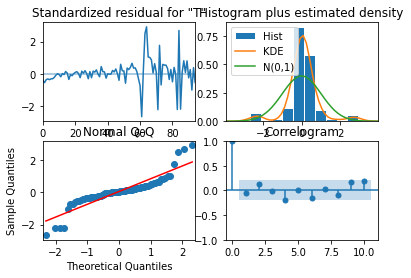

In [78]:
# Create the 4 diagostics plots
model.plot_diagnostics()
plt.show()

In [79]:
forecast_CI = pd.concat([forecast, CI], axis=1)

In [80]:
forecast_CI

,Values,lower_CI,Upper_CI
Feb-23,7.087460e+08,6.649888e+08,7.556843e+08
Mar-23,7.225544e+08,6.671143e+08,7.728310e+08
Apr-23,7.363628e+08,6.694799e+08,8.016550e+08
May-23,7.501713e+08,6.723739e+08,8.241924e+08
Jun-23,7.639797e+08,6.755446e+08,8.492352e+08
Jul-23,7.777881e+08,6.786628e+08,8.729864e+08
Aug-23,7.915965e+08,6.818149e+08,8.973532e+08
Sep-23,8.054050e+08,6.848549e+08,9.215182e+08
Oct-23,8.192134e+08,6.878099e+08,9.459199e+08
Nov-23,8.330218e+08,6.906277e+08,9.703855e+08


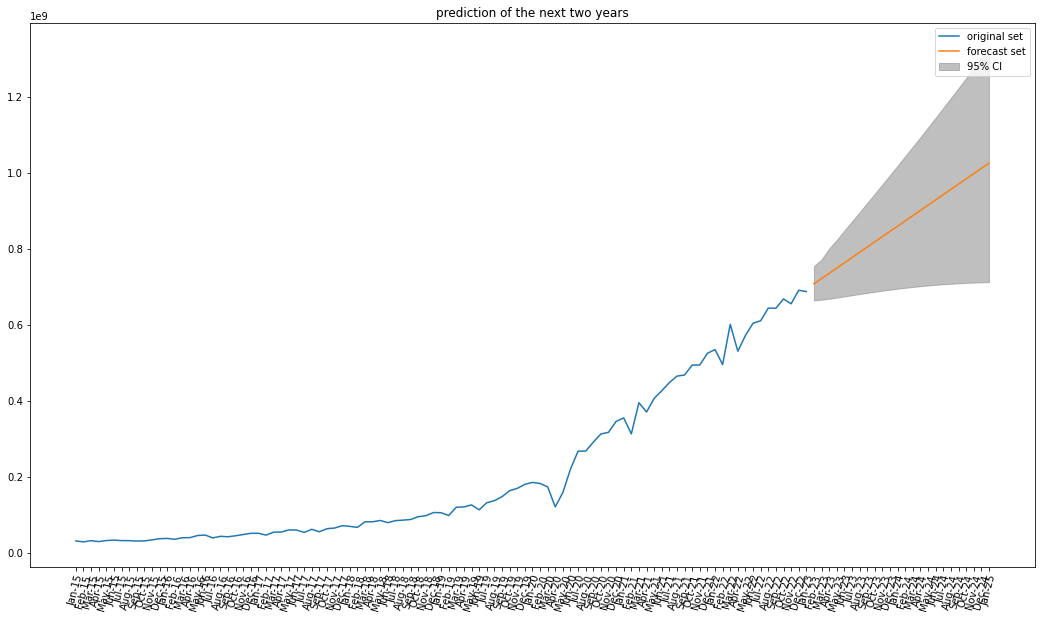

In [81]:
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.plot(clean_POS, label = 'original set')
plt.plot(forecast , label='forecast set')
plt.fill_between(forecast_CI.index, forecast_CI.lower_CI, forecast_CI.Upper_CI, alpha=0.5, color='gray', label='95% CI')
plt.xticks(rotation=75)
plt.xticks()
plt.legend()
plt.title('prediction of the next two years')
plt.show() 

<h3> Ponus, trying auto arima function


In [35]:
split_index = int(0.80 * len(clean_POS))
auto_train_data = clean_POS.iloc[:split_index, :]
auto_test_data = clean_POS.iloc[split_index:, :]

In [36]:
auto_model = auto_arima(auto_train_data)

/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.po

In [37]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -1358.207
Date:                Mon, 20 Mar 2023   AIC                           2722.413
Time:                        23:00:06   BIC                           2729.365
Sample:                             0   HQIC                          2725.189
                                 - 77                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1524      0.081    -14.158      0.000      -1.312      -0.993
ma.L2          0.2202      0.064      3.463      0.001       0.096       0.345
sigma2      3.862e+14   4.03e-18   9.59e+31      0.000    3.86e+14    3.86e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               135.11
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              33.40   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.15e+48. Standard errors may be unstable.
"""

In [38]:
auto_y_pred = pd.DataFrame(index= auto_test_data.index)
auto_y_pred['Total'] = auto_model.predict(len(auto_test_data)).values

/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [39]:
KPI(y_pred=auto_y_pred, test_data=auto_test_data)

mape = 0.052065296663275175
mae = 30086576.721661
mse = 1123490946032468.2
rmse = 33518516.465268392


In [40]:
auto_model = auto_arima(clean_POS)
auto_y_pred = pd.DataFrame(index= date_index)
auto_y_pred['Total'] = auto_model.predict(len(date_index)).values


/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/nawaf/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.po

In [41]:
auto_y_pred.index = auto_y_pred.index.strftime("%b-%y")

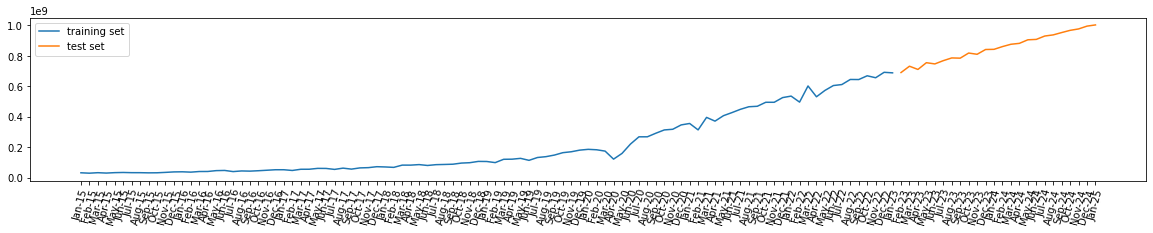

In [42]:
fig = plt.gcf()
fig.set_size_inches(20, 3)
plt.plot(clean_POS, label = 'training set')
plt.plot(auto_y_pred.Total, label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 

<h3> let's compare these two models, my model and the auto arima model

In [82]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1735.947
Date:                Mon, 20 Mar 2023   AIC                           3477.893
Time:                        23:13:29   BIC                           3485.555
Sample:                             0   HQIC                          3480.989
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4228      0.087    -16.387      0.000      -1.593      -1.253
ma.L2          0.4819      0.077      6.288      0.000       0.332       0.632
sigma2      6.206e+14        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                98.71
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):              29.16   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.93e+47. Standard errors may be unstable.
"""

In [55]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1725.841
Date:                Mon, 20 Mar 2023   AIC                           3465.681
Time:                        23:04:42   BIC                           3483.558
Sample:                             0   HQIC                          3472.905
                                 - 97                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3120      0.107    -21.603      0.000      -2.522      -2.102
ar.L2         -1.9342      0.145    -13.323      0.000      -2.219      -1.650
ar.L3         -0.5608      0.067     -8.332      0.000      -0.693      -0.429
ma.L1          0.9497      0.110      8.601      0.000       0.733       1.166
ma.L2         -0.7571      0.107     -7.107      0.000      -0.966      -0.548
ma.L3         -0.8671      0.121     -7.170      0.000      -1.104      -0.630
sigma2      3.997e+14   2.62e-16   1.52e+30      0.000       4e+14       4e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               148.89
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):              23.63   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.87e+45. Standard errors may be unstable.
"""